In [1]:
import json 


def read_json(path):
    with open(path) as f1:
        data = [json.loads(x) for x in f1]
    return data


calflow_path = "/brtx/602-nvme1/estengel/calflow_calibration/benchclamp/logs/1.0/bart-large_calflow_last_user_all_0.0001_10000_test_eval_unconstrained-beam_bs_5/model_outputs.20221101T105421.jsonl"

calflow_data = read_json(calflow_path)

treedst_path = "/brtx/602-nvme1/estengel/calflow_calibration/benchclamp/logs/1.0/bart-large_tree_dst_last_user_all_0.0001_10000_test_eval_unconstrained-beam_bs_5/model_outputs.20221102T103357.jsonl"

treedst_data = read_json(treedst_path)







# Factors making examples easy and hard
Which factors make an example easy or hard? We will look at 3 factors:
- length (numer of tokens)
- number of sentences 
- percentage of value op values that are present in the source 

## Length

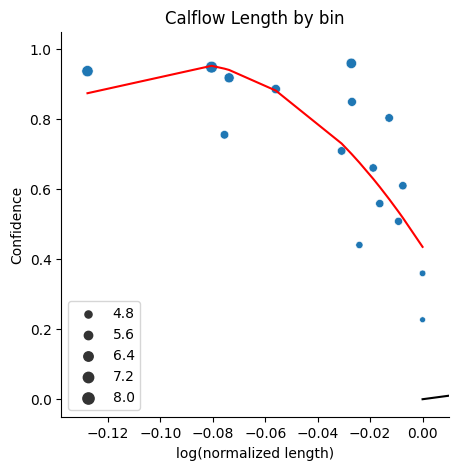

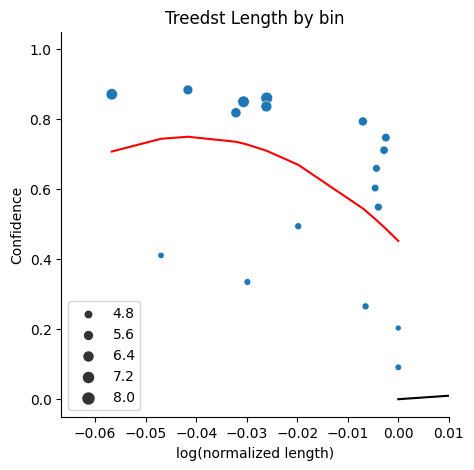

In [2]:
import re
import numpy as np 
# get input length
from matplotlib import pyplot as plt 

from calibration_metric import ECEMetric
from calibration_metric.vis.calibration_plot import plot_df

def get_lengths_and_confidences(data):
    lens = []
    confs = []
    for example in data:
        input_str = example['test_datum_natural'].split("|")[-1].strip()
        input_str = re.split("\s+", input_str) 
        lens.append(len(input_str)) 
        token_probs = np.exp(example['token_logprobs'][0])
        min_conf = np.min(token_probs) 
        # min_conf = np.min(example['top_logits'], axis=-1)
        confs.append(min_conf)
    lens = np.array(lens)
    # normalize lengths
    max_len = np.max(lens)
    min_len = np.min(lens)
    len_range = max_len - min_len
    lens = (lens - min_len) / len_range

    confs = np.array(confs)
    metric = ECEMetric(binning_strategy='adaptive', return_df=True)
    values, bin_edges, bin_number = metric.bin_preds(confs, lens)
    df = metric.bins_to_df(values, bin_edges, bin_number)

    return df 


calflow_len_df = get_lengths_and_confidences(calflow_data)
fig, ax = plt.subplots(1,1, figsize=(5, 5))
# take log of normalized length
calflow_len_df['prob_correct'] = np.log(calflow_len_df['prob_correct'])

plot_df(df = calflow_len_df,
        use_log_count=True,
        ax=ax,
        title="Calflow Length by bin",
        xlabel="log(normalized length)",
        ylabel="Confidence")

ax.set_xlim(calflow_len_df['prob_correct'].min()-0.01, calflow_len_df['prob_correct'].max()+0.01)
# sort by length
calflow_len_df = calflow_len_df.sort_values(by='prob_correct')
# fit 2nd order polynomial
fit = np.polyfit(calflow_len_df['prob_correct'], calflow_len_df['prob_model'], 2)
ax.plot(calflow_len_df['prob_correct'], np.polyval(fit, calflow_len_df['prob_correct']), color='red')



treedst_len_df = get_lengths_and_confidences(treedst_data)
fig, ax = plt.subplots(1,1, figsize=(5, 5))
# take log of normalized length
treedst_len_df['prob_correct'] = np.log(treedst_len_df['prob_correct'])

plot_df(df = treedst_len_df,
        use_log_count=True,
        ax=ax,
        title="Treedst Length by bin",
        xlabel="log(normalized length)",
        ylabel="Confidence")

ax.set_xlim(treedst_len_df['prob_correct'].min()-0.01, treedst_len_df['prob_correct'].max()+0.01)
# sort by length
treedst_len_df = treedst_len_df.sort_values(by='prob_correct')
# fit 2nd order polynomial
fit = np.polyfit(treedst_len_df['prob_correct'], treedst_len_df['prob_model'], 2)
ax.plot(treedst_len_df['prob_correct'], np.polyval(fit, treedst_len_df['prob_correct']), color='red')

Clear negative correlation between log normalized length and confidence; Longer programs are lower confidence



## Percentage of examples with multiple sentences
For each dataset, what percentage of examples have more than one sentence (as measured by the presence of a period)

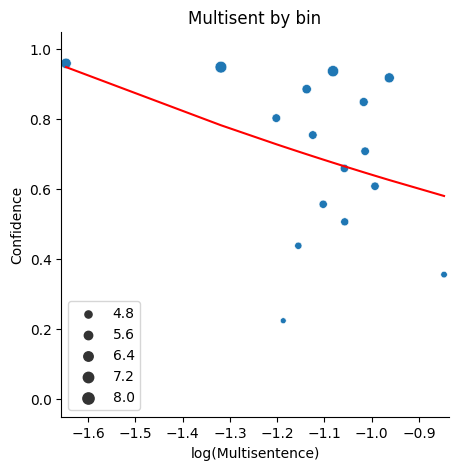

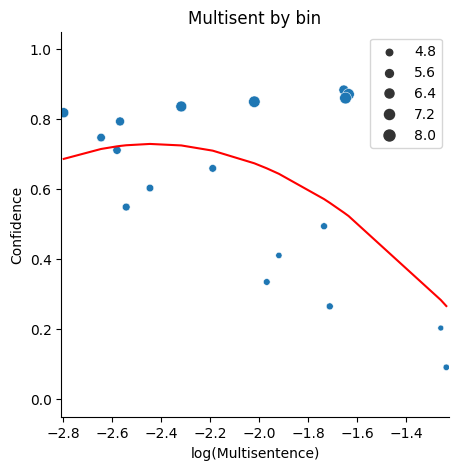

In [3]:
def get_multisent_and_confidences(data):
    multis = []
    confs = []
    for example in data:
        input_str = example['test_datum_natural'].split("|")[-1].strip()
        input_str = re.sub("\.", " . ", input_str)
        split_input = re.split("\s+", input_str) 
        if split_input[-1] == ".":
            split_input = split_input[0:-1]
        if "." in split_input: 
            period_index = split_input.index(".")
            try:
                before, after = split_input[period_index-1], split_input[period_index+1]
                # check if they're numbers 
                if before.isdigit() and after.isdigit():
                    continue
            except IndexError:
                pass
            multi_sent = 1 
        else:
            multi_sent = 0
        multis.append(multi_sent)
        token_probs = np.exp(example['token_logprobs'][0])
        min_conf = np.min(token_probs) 
        confs.append(min_conf)

    multis = np.array(multis)
    confs = np.array(confs)

    metric = ECEMetric(binning_strategy='adaptive', return_df=True)
    values, bin_edges, bin_number = metric.bin_preds(confs, multis)
    df = metric.bins_to_df(values, bin_edges, bin_number)

    return df 


calflow_multi_df = get_multisent_and_confidences(calflow_data)
calflow_multi_df['prob_correct'] = np.log(calflow_multi_df['prob_correct'])

fig, ax = plt.subplots(1,1, figsize=(5, 5))
plot_df(df = calflow_multi_df,
        use_log_count=True,
        ax=ax,
        title="Multisent by bin",
        xlabel="log(Multisentence)",
        ylabel="Confidence")


ax.set_xlim(calflow_multi_df['prob_correct'].min()-0.01, calflow_multi_df['prob_correct'].max()+0.01)
# sort by length
calflow_multi_df = calflow_multi_df.sort_values(by='prob_correct')
# fit 2nd order polynomial
fit = np.polyfit(calflow_multi_df['prob_correct'], calflow_multi_df['prob_model'], 2)
ax.plot(calflow_multi_df['prob_correct'], np.polyval(fit, calflow_multi_df['prob_correct']), color='red')

treedst_multi_df = get_multisent_and_confidences(treedst_data)
treedst_multi_df['prob_correct'] = np.log(treedst_multi_df['prob_correct'])

fig, ax = plt.subplots(1,1, figsize=(5, 5))
plot_df(df = treedst_multi_df,
        use_log_count=True,
        ax=ax,
        title="Multisent by bin",
        xlabel="log(Multisentence)",
        ylabel="Confidence")


ax.set_xlim(treedst_multi_df['prob_correct'].min()-0.01, treedst_multi_df['prob_correct'].max()+0.01)
# sort by length
treedst_multi_df = treedst_multi_df.sort_values(by='prob_correct')
# fit 2nd order polynomial
fit = np.polyfit(treedst_multi_df['prob_correct'], treedst_multi_df['prob_model'], 2)
ax.plot(treedst_multi_df['prob_correct'], np.polyval(fit, treedst_multi_df['prob_correct']), color='red')


Negative correlation again; the more multi-sentence examples in a bin, the more likely it is to be low-confidence

TODO: Fit a line


## Copying
For TreeDST, it seems like a lot of hard examples are based on not having access to enough context.
We will see what percentage of values_op values we can copy from the input 

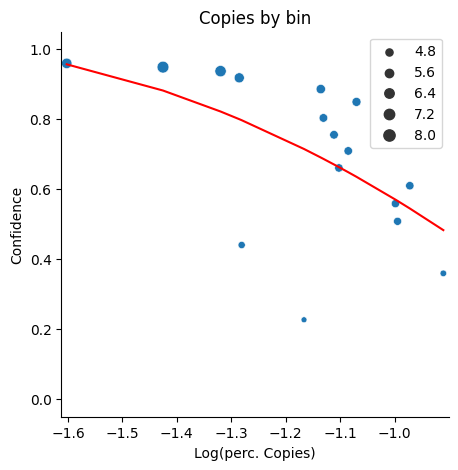

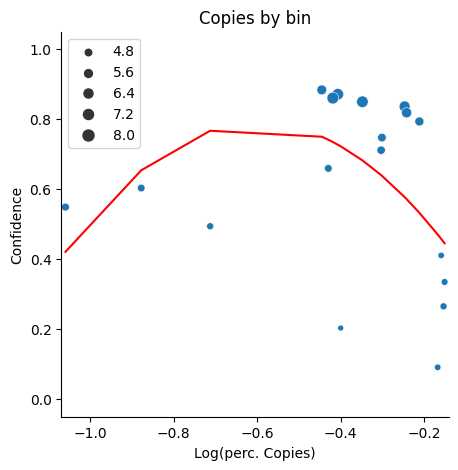

In [4]:
## get set of value ops 
from dataflow.core.lispress import parse_lispress, lispress_to_program
from dataflow.core.program import ValueOp
def get_value_ops(lispress):
    all_values = []
    lispress = parse_lispress(lispress)
    program, __ = lispress_to_program(lispress, 0)
    for expression in program.expressions:
        if isinstance(expression.op, ValueOp):
            underlying = str(json.loads(expression.op.value)['underlying']).strip()
            all_values.append(underlying.lower())
    return all_values 


def get_copies_and_confidences(data):
    copies = []
    confs = []
    for example in data:
        # use full context 
        input_str = example['test_datum_natural'].strip()
        input_str = re.sub("\.", " . ", input_str)
        split_input = re.split("\s+", input_str) 
        split_input = [x.lower().strip() for x in split_input]
        value_ops = get_value_ops(example['test_datum_canonical'])
        # get percentage of value ops in input 
        in_input, total = 0, 0
        for v in value_ops:
            if v in split_input:
                in_input += 1
            total += 1
        if total > 0:
            c = in_input/total
        else:
            c = 0
        copies.append(c)
        token_probs = np.exp(example['token_logprobs'][0])
        min_conf = np.min(token_probs) 
        confs.append(min_conf)

    confs = np.array(confs)
    copies = np.array(copies)

    metric = ECEMetric(binning_strategy='adaptive', return_df=True)
    values, bin_edges, bin_number = metric.bin_preds(confs, copies)
    df = metric.bins_to_df(values, bin_edges, bin_number)

    return df 

calflow_copies_df = get_copies_and_confidences(calflow_data)
calflow_copies_df['prob_correct'] = np.log(calflow_copies_df['prob_correct'])
fig, ax = plt.subplots(1,1, figsize=(5, 5))
plot_df(df = calflow_copies_df,
        use_log_count=True,
        ax=ax,
        title="Calflow Copies by bin",
        xlabel="Log(perc. Copies)",
        ylabel="Confidence")

ax.set_xlim(calflow_copies_df['prob_correct'].min()-0.01, calflow_copies_df['prob_correct'].max()+0.01)
# sort by length
calflow_copies_df = calflow_copies_df.sort_values(by='prob_correct')
# fit 2nd order polynomial
fit = np.polyfit(calflow_copies_df['prob_correct'], calflow_copies_df['prob_model'], 2)
ax.plot(calflow_copies_df['prob_correct'], np.polyval(fit, calflow_copies_df['prob_correct']), color='red')


treedst_copies_df = get_copies_and_confidences(treedst_data)
treedst_copies_df['prob_correct'] = np.log(treedst_copies_df['prob_correct'])
fig, ax = plt.subplots(1,1, figsize=(5, 5))
plot_df(df = treedst_copies_df,
        use_log_count=True,
        ax=ax,
        title="Treedst Copies by bin",
        xlabel="Log(perc. Copies)",
        ylabel="Confidence")

ax.set_xlim(treedst_copies_df['prob_correct'].min()-0.01, treedst_copies_df['prob_correct'].max()+0.01)
# sort by length
treedst_copies_df = treedst_copies_df.sort_values(by='prob_correct')
# fit 2nd order polynomial
fit = np.polyfit(treedst_copies_df['prob_correct'], treedst_copies_df['prob_model'], 2)
ax.plot(treedst_copies_df['prob_correct'], np.polyval(fit, treedst_copies_df['prob_correct']), color='red')

Also a negative correlation here; as the log percentage of course copies increases, the confidence decreases. 
Means the opposite of the others: the more we can source copy, the more difficult (low confidence) the example is; reflected in the aggregate numbers for Easy and Hard split

Note that the correlation doesn't hold for TreeDST, which also corresponds to the stats we saw for the easy/hard splits 
